# Causality

To make better decisions with our statistical and ML models, I will explore the causal relationships for both winning MTG.  This analysis will be informal and exploratory.  I will use the [directed acyclic graph (DAG) framework](https://mixtape.scunning.com/03-directed_acyclical_graphs) to identify potential causal relationships between card attributes and win rate.

Later, we may do more formal causal inference using the [doWhy](https://microsoft.github.io/dowhy/) and [CausalImpact](https://google.github.io/CausalImpact/CausalImpact.html) libraries and test for identifiability, consistency, and robustness of our causal models.

For a more in-depth discussion of causality in data science, refer to the works of [Judea Pearl](https://en.wikipedia.org/wiki/Judea_Pearl) or [Richard McElreath](https://xcelab.net/rm/statistical-rethinking/).



---

## Card Impact in Draft Play

Let's look at the causal relationship between a card and it ability to affect a player's success in draft play.

### Card Impact

I will use the term __impact__ to describe the ability of a card to contribute to winning a game.  The impact of the card is the abstract concept that we are trying to measure.  The impact of a card is not directly observable, but we can infer it from the a player's success with or without the card in the play deck.

Common terms for card impact can be __power level__ or __playability__.  These terms are often used interchangeably, but I will use impact to describe the abstract concept of a card's ability to contribute to winning a game.

While impact can not be directly measured or observed, the card's rarity (common, uncommon, rare, mythic rare) is often used as a proxy for the cards impact.  This is an imperfect measure of impact and ideally I will find a more reliable means of modeling impact.

I'll start a DAG with the impact.  Since the impact can not be directly measured or observed, I mark it with a dashed line to indicate it is a __latent variable__.

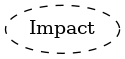

In [39]:

from graphviz import Digraph
from IPython.display import Image

# Initialize a directed graph
dot = Digraph(comment='Card Impact', format='png')
dot.attr(rankdir='LR')

# Define the impact node
dot.node(name='I', label='Impact', shape='oval', style='dashed')

# Render and display the graph in Jupyter Notebook
Image(dot.render(filename='../images/dags/dags', format='png', cleanup=True))

### Card Success

I am calling the outcome of using a card in a deck that card's __success__.  This abstract concept can take many forms.  The obvious one is the __win rate__ of a deck containing the card and can be expanded to a player's __win record__ when using a given deck.  Other forms can be the card's __pick rate__ in a draft or the card's __play rate__ from the hand.  When looking at replay data, one can also examine resource trade-off, such as the __card exchange rate__ - how many cards are consumed by the player versus the opponent when playing a given card.

The __win rate__ can further be refined, such as the __starting hand win rate__, the __non-starting hand win rate__, and the __not in hand win rate__ indicating the win rate if a card is played from the starting hand, played when not in starting hand, or never played.

I infer that impact of the played cards will effect the success of the game.  I'll update the DAG to reflect this.


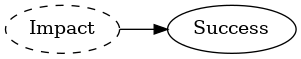

In [40]:
# Add success node
dot.node(name='S', label='Success', shape='oval')

# Define edges for fields and relationships
dot.edge(tail_name='I', head_name='S')


# Render and display the graph in Jupyter Notebook
Image(dot.render(filename='../images/dags/dags', format='png', cleanup=True))

### Card Attributes

A card's attributes are the aspect of the card that affect playability.  I will only include items that directly affect a card's impact.

Attributes affecting Impact:
- __Mana Cost__
- __Card Type__ - (creature, instant, etc.)
- __Power/Toughness__
- __Keywords__
- __Text Description__

A lot of attributes do not affect a card's impact, but are used as proxies for impact.

Proxy Attributes:
- __Rarity__ - While the rarity itself does not affect a card's impact, more rare cards often correlate with higher card impact.  But changing or removing the rarity symbol on a card would have no mechanical affect.
- __Card Name__ - perhaps a bit philosophical,  the name itself does not affect a card's impact. One can have mechanically equivalent cards with different names (_"...a black lotus by any other name..."_).
- __Set__ - often used as a proxy, as some sets are seen as more powerful that others.
- __Variant Art__ - affects collectablity and price, but not game play.

The DAG is updated to show how attributes affect impact.

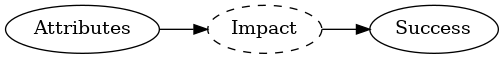

In [41]:
dot.node(name='A', label='Attributes', shape='oval')
dot.edge(tail_name='A', head_name='I')
Image(dot.render(filename='../images/dags/dags', format='png', cleanup=True))

### Context within Deck Composition

If a card interacts well with the other cards in it's deck, that will increase the card's impact in a game.  

An obvious example of this interaction is the problem of adding a mythic rare green card will to a deck without green mana.  This card will not be playable and it will act as dead-weight in the deck.  This card would have negative impact on game success.

Conversely, a card that adds bonuses to tokens in a deck with lots of token generation would have a large positive impact.  Below I update the DAG to reflect this relationship.


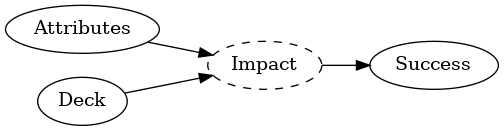

In [42]:
dot.node(name='D', label='Deck', shape='oval')
dot.edge(tail_name='D', head_name='I')
Image(dot.render(filename='../images/dags/dags', format='png', cleanup=True))

### Player Skill

A card's impact is situational, with a highly skill player will using a card in ways to maximize this impact.  This can be done in drafting, deck building, and game play.

A low skilled player with high impact cards could have game success equal to a high skilled player with low impact cards.  Increasing both skill and impact should increase success.

Since a player's skill can affect both deck composition and situational card impact, the DAG is updated accordingly.  We can't directly observe a player's skill, so it is indicated as a latent variable.

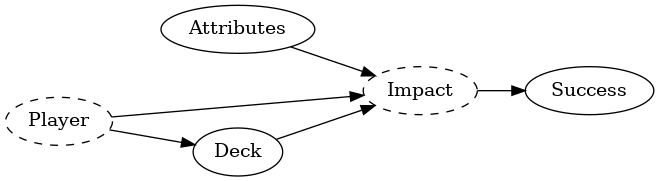

In [43]:
dot.node(name='P', label='Player', shape='oval', style='dashed')
dot.edge(tail_name='P', head_name='I')
dot.edge(tail_name='P', head_name='D')
Image(dot.render(filename='../images/dags/dags', format='png', cleanup=True))

### Board State

The board state also affects a card's impact.  A card that gives bonuses to all tokens in play has much higher impact when the player has many tokens in play.

The board state can be both permanent resources (creatures, life, cards in hand) and temporary resources (untapped lands, untapped creatures).

The current board state affects a card's impact.   The card can then affect the future board state.  This results in a causal loop that isn't well suited for the DAG approach, so I will only consider the current board state on card impact.

A player's skill also affects the board state, with skilled players building states that better favor cards to be played.

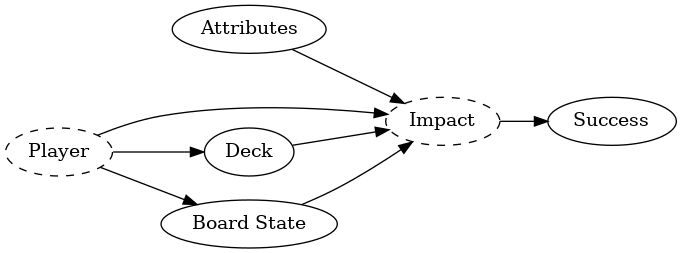

In [44]:
dot.node(name='B', label='Board State', shape='oval')
dot.edge(tail_name='B', head_name='I')
dot.edge(tail_name='P', head_name='B')
Image(dot.render(filename='../images/dags/dags', format='png', cleanup=True))

### Opponents

Since this is a competitive game, the opponent will also affect the current board state.  An opponent's skill is also unobservable.

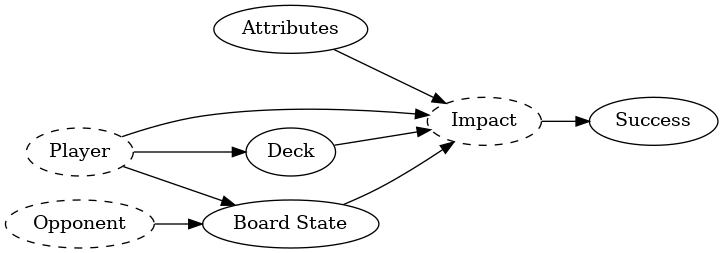

In [45]:
dot.node(name='O', label='Opponent', shape='oval', style='dashed')
dot.edge(tail_name='O', head_name='B')
Image(dot.render(filename='../images/dags/dags', format='png', cleanup=True))

### Conclusion

We can see above that a lot of factors affect a card's impact on game play success.  The card's attributes, the deck composition, and board state are all observable, so we will build models that account for this.  Conversely, the player's skill and the opponent's skill and deck are unobserved, and will be more challenging to model.  

The first step will to do some [exploratory data analysis](../10-wrangle+eda).  I will then develop some models to explore these causal relationship and infer the latent variables, such as card impact and player skill.

---

## Secondary Card Value

In a separate analysis, I will explore the economic causal relationships in the secondary card market.

I assume there is some relationship between a card's __impact__ in game play and the card's __value__ on the secondary market.  Below is a DAG with both nodes added.  We can observe price, but not card impact.

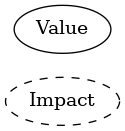

In [46]:
dot = Digraph(comment='Card Value', format='png')
dot.attr(rankdir='LR')
dot.node(name='I', label='Impact', shape='oval', style='dashed')
dot.node(name='V', label='Value', shape='oval')
Image(dot.render(filename='../images/dags/dags', format='png', cleanup=True))

### Supply and Demand

The conventional wisdom in economics is that __demand__ pressure to acquire the card will positively affect price.  Conversely, increased __supply__ of a card for a fixed demand will drive down price.

Both supply and demand are unobserved phenomenon.

A card's impact in game play will affect demand.  Higher impact cards will typically be in higher demand.

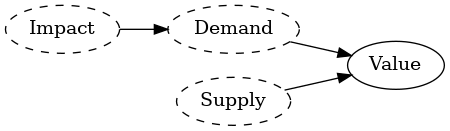

In [47]:
dot.node(name='S', label='Supply', shape='oval', style='dashed')
dot.node(name='D', label='Demand', shape='oval', style='dashed')
dot.edge(tail_name='I', head_name='D')
dot.edge(tail_name='S', head_name='V')
dot.edge(tail_name='D', head_name='V')
Image(dot.render(filename='../images/dags/dags', format='png', cleanup=True))

### Print Supply

How does a card's __rarity__ work in this DAG?  In the context of a given set, we know high rarity cards are printed less.  

__Reprints__ of a card in new sets will increase supply.

Across sets, we will assume that more rare cards will be reprinted less frequently.  This assumption should be tested.

Both rarity and reprints can be combined into a card's __print quantity__, which is the primary market supply controlled by WOTC.

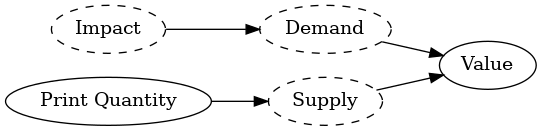

In [48]:
dot.node(name='P', label='Print Quantity', shape='oval')
dot.edge(tail_name='P', head_name='S')
Image(dot.render(filename='../images/dags/dags', format='png', cleanup=True))

### Market Hype

There is also a element of market __hype__ that impacts the supply and demand of card.  This can be from the card's use in a high-profile tournament, popularity with collectors of an alternate art piece, or financial market bear and bull feedback.

Regardless of the source, a given card value may be misaligned from it's game play impact and primary print supply.

Hype is also a latent variable.

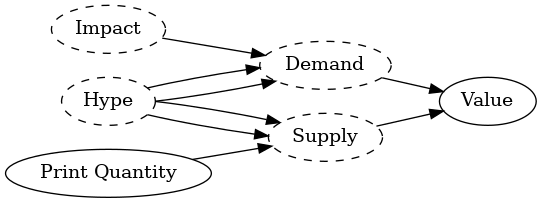

In [50]:
dot.node(name='H', label='Hype', shape='oval', style='dashed')
dot.edge(tail_name='H', head_name='D')
dot.edge(tail_name='H', head_name='S')
Image(dot.render(filename='../images/dags/dags', format='png', cleanup=True))

### Conclusion

As can be seen above, secondary market demand, secondary market supply, card game play impact, and market hype are all unobserved.  This one reason financial markets are so hard to model.  

The print quantity of a given card is proprietary information, with data on number of card sheet printings and booster pack composition not public data.  We can infer this information by estimate card sheet composition, booster deck composition, and retail sales quantities.

Finally, all of these factors vary as a function of time.  Reprintings, hype and value will change over time, as we well know.  Even the card's impact on game play will change as new sets are released and old ones are phased out of formats such as Standard.

I will dive into this topic of estimating card value after exploring card impact in draft play.